In [32]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def read_image(file_name: str):
    return cv2.imread(file_name)

def colour2bw(image):
    grey_horse = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (_, white_horse) = cv2.threshold(grey_horse, 10, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return white_horse

def image2pixels(bw_image):    
    # Initialise arrays to store positions of each pixel
    x_pixels = np.zeros(len(bw_image.flatten()))
    y_pixels = np.zeros(len(bw_image.flatten()))
    # Store position of each pixel
    count = 0
    for row in range(bw_image.shape[0]):
        for column in range(bw_image.shape[1]):
            if bw_image[row,column] != 0:
                x_pixels[count] = column
                y_pixels[count] = -row
            count += 1
    # Remove datapoints where there are no pixels
    x_pixels = x_pixels[x_pixels != 0]
    y_pixels = y_pixels[y_pixels != 0]
    return x_pixels, y_pixels

def file2pixels(file_name: str):
    image = read_image(file_name)
    bw_image = colour2bw(image)
    x_pixels, y_pixels = image2pixels(bw_image)
    return bw_image, (x_pixels, y_pixels)

## Display images and pixel images

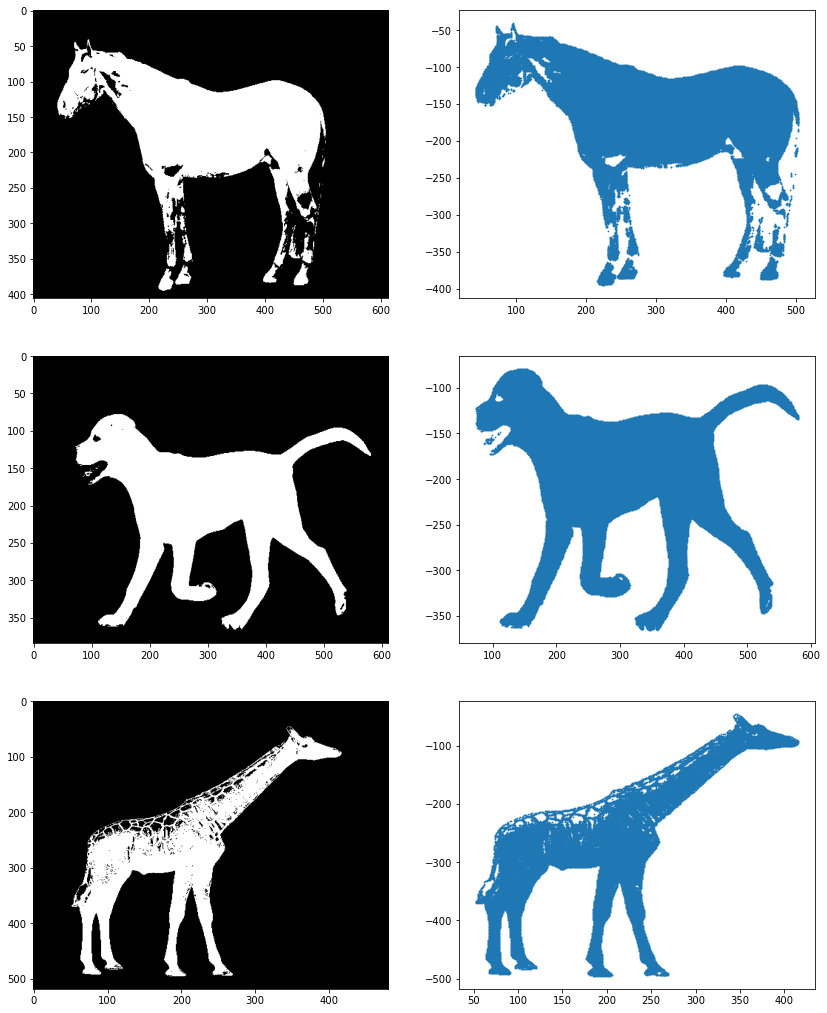

In [87]:
# Collect data
horse = file2pixels('Images/horse.png')
poochie = file2pixels('Images/DogNoBg.png')
girrafe = file2pixels('Images/GiraffeNoBG.png')

horse_xy = np.array(horse[1][:])
horse_xy = np.transpose(horse_xy)
# Make figure
fig, ax = plt.subplots(3, 2, figsize=(14,18))

# Plot horse
ax[0][0].imshow(horse[0], cmap='gray', aspect='auto')
ax[0][1].scatter(horse[1][0], horse[1][1], s=0.5)

# Plot poochie
ax[1][0].imshow(poochie[0], cmap='gray', aspect='auto')
ax[1][1].scatter(poochie[1][0], poochie[1][1], s=0.5)

# Plot giraffe
ax[2][0].imshow(girrafe[0], cmap='gray', aspect='auto')
ax[2][1].scatter(girrafe[1][0], girrafe[1][1], s=0.5)

plt.show()

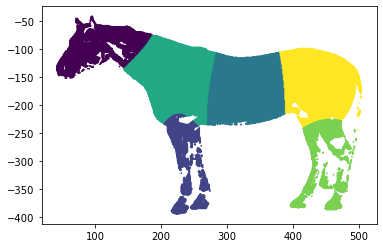

In [89]:
from sklearn import mixture
from sklearn.mixture import GaussianMixture as GMM

gmm_model = GMM(n_components=6, covariance_type= 'full', random_state=0).fit(horse_xy)

gmm_labels = gmm_model.predict(horse_xy)

plt.scatter(horse[1][0], horse[1][1], c=gmm_labels, s=0.5, cmap='viridis');


In [91]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    gmm_labels = gmm.fit(horse_xy).predict(horse_xy)
    if label:
        ax.scatter(horse[1][0], horse[1][1], c=gmm_labels, s=0.5, cmap='viridis', zorder=2)
    else:
        ax.scatter(horse[1][0], horse[1][1], s=0.5, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

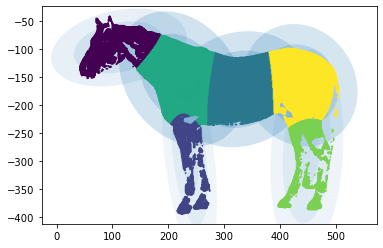

In [108]:
gmm = mixture.GaussianMixture(n_components=6, random_state=0)

plot_gmm(gmm, horse[1][:])

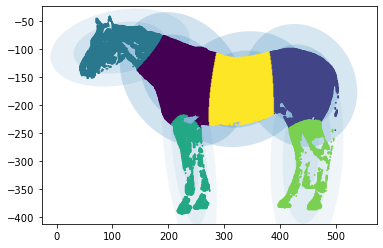

In [95]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full', random_state=42)
plot_gmm(gmm, horse[1][:])